# cml1 - Immobilienrechner
# 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vergleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.

## Module importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# tree models
from sklearn.tree import DecisionTreeRegressor

# ensemble models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# xgb model
import xgboost as xgb
from xgboost import XGBRegressor

# imputing
from sklearn.impute import SimpleImputer, KNNImputer

# preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

# pipeline
from sklearn.pipeline import Pipeline

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV

# metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# save model
import pickle

## Daten laden

Damit die Predictions die korrekten IDs haben, müssen die rohe Kaggle-Daten geladen werden und die IDs extrahiert werden. Diese werden wir später wieder benötigen.

In [2]:
df_raw_kaggle = pd.read_csv('../../../data/test_data-Kaggle-v0.11.csv', low_memory=False)

# get indexes for predictions
indexes = df_raw_kaggle["Unnamed: 0"]

In [3]:
df = pd.read_csv('../../../data/immo_data_clean.csv', low_memory=False)
df_kaggle = pd.read_csv('../../../data/test_data_kaggle_clean.csv', low_memory=False)

In [4]:
df = df.drop(columns=[
	"Zip",
	"Availability_Categorized",

	"Floor_unified", 
    "gde_politics_bdp",
    "gde_politics_cvp",
    "gde_politics_evp",
    "gde_politics_fdp",
    "gde_politics_glp",
    "gde_politics_gps",
    "gde_politics_pda",
    "gde_politics_rights",
    "gde_politics_sp",
    "gde_politics_svp",

    "NoisePollutionRailwayL", "NoisePollutionRailwayM", "NoisePollutionRailwayS", 
    "NoisePollutionRoadL", "NoisePollutionRoadM", "NoisePollutionRoadS", 
    "PopulationDensityL", "PopulationDensityM", "PopulationDensityS", 
    "RiversAndLakesL", "RiversAndLakesM", "RiversAndLakesS", 
    "WorkplaceDensityL", "WorkplaceDensityM", "WorkplaceDensityS", 
    "ForestDensityL", "ForestDensityM", "ForestDensityS"
])
df_kaggle = df_kaggle.drop(columns=[
	"Zip",
	"Availability_Categorized",

	"Floor_unified", 
    "gde_politics_bdp",
    "gde_politics_cvp",
    "gde_politics_evp",
    "gde_politics_fdp",
    "gde_politics_glp",
    "gde_politics_gps",
    "gde_politics_pda",
    "gde_politics_rights",
    "gde_politics_sp",
    "gde_politics_svp",

    "NoisePollutionRailwayL", "NoisePollutionRailwayM", "NoisePollutionRailwayS", 
    "NoisePollutionRoadL", "NoisePollutionRoadM", "NoisePollutionRoadS", 
    "PopulationDensityL", "PopulationDensityM", "PopulationDensityS", 
    "RiversAndLakesL", "RiversAndLakesM", "RiversAndLakesS", 
    "WorkplaceDensityL", "WorkplaceDensityM", "WorkplaceDensityS", 
    "ForestDensityL", "ForestDensityM", "ForestDensityS"
])

## Daten vorbereiten

In [5]:
def preprocess_dataframe(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    df_processed = pd.get_dummies(df, columns=categorical_columns, drop_first=True, dtype=int)

    return df_processed, numerical_columns


def remove_outliers(df, numerical_columns):
    df_processed = df.copy()

    quantiles_1 = df_processed[numerical_columns].quantile(0)
    quantiles_99 = df_processed[numerical_columns].quantile(0.99)

    for column in numerical_columns:
        condition = (df_processed[column] < quantiles_1[column]) | (df_processed[column] > quantiles_99[column])
        df_processed.loc[condition, column] = None

    return df_processed

df, num_cols_df = preprocess_dataframe(df)
df_kaggle, num_cols_df_kaggle = preprocess_dataframe(df_kaggle)

#df = remove_outliers(df, num_cols_df)

df = df[df['price_cleaned'] > 10000]

df = df.dropna(subset=['price_cleaned'], axis=0)

print("Dataset after removing rows with missing target values:")
print(df.shape)

print("Kaggle Test Dataset")
print(df_kaggle.shape)

Dataset after removing rows with missing target values:
(21444, 64)
Kaggle Test Dataset
(24556, 64)


In [6]:
df.dtypes

price_cleaned                     float64
Year built:                       float64
Living_area_unified               float64
Floor_space_merged                float64
Plot_area_unified                 float64
                                   ...   
type_unified_stepped-apartment      int32
type_unified_stepped-house          int32
type_unified_studio                 int32
type_unified_terrace-house          int32
type_unified_villa                  int32
Length: 64, dtype: object

In [7]:
columns_df1 = set(df.columns)
columns_df2 = set(df_kaggle.columns)

# Compare the sets of columns
if columns_df1 == columns_df2:
    print("The dataframes have the same column names.")
else:
    print("The dataframes do not have the same column names.")

    # Find out which columns are different
    diff_df1 = columns_df1 - columns_df2
    diff_df2 = columns_df2 - columns_df1

    if diff_df1:
        print("Columns in df1 not in df2:", diff_df1)
    if diff_df2:
        print("Columns in df2 not in df1 (dropped):", diff_df2)
        df_kaggle.drop(diff_df2, axis=1, inplace=True)

The dataframes do not have the same column names.
Columns in df1 not in df2: {'price_cleaned'}
Columns in df2 not in df1 (dropped): {'type_unified_furnished-residential-property'}


## Train Test Split

In [8]:
train, val = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop("price_cleaned", axis=1)
y_train = train["price_cleaned"]

X_val= val.drop("price_cleaned", axis=1)
y_val = val["price_cleaned"]

X_test_kaggle = df_kaggle

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_val.shape)
print("y_test shape: ", y_val.shape)
print("X_test_kaggle shape: ", X_test_kaggle.shape)

X_train shape:  (17155, 63)
y_train shape:  (17155,)
X_test shape:  (4289, 63)
y_test shape:  (4289,)
X_test_kaggle shape:  (24556, 63)


## Imputation

In [9]:
cols = X_train.columns

X_train_with_na = X_train.copy()
X_val_with_na = X_val.copy()
X_test_kaggle_with_na = X_test_kaggle.copy()
X_test_kaggle_with_na = X_test_kaggle_with_na[cols]

In [10]:
imputer = KNNImputer(n_neighbors=3)

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=cols)
X_test_kaggle_imputed = pd.DataFrame(imputer.fit_transform(df_kaggle), columns=cols)

# export imputed train and test data to csv so we dont always have to run the imputation
X_train_imputed.to_csv('../../../data/X_train_imputed.csv')
X_val_imputed.to_csv('../../../data/X_test_imputed.csv')
X_test_kaggle_imputed.to_csv('../../../data/X_test_kaggle_imputed.csv')

y_train.to_csv('../../../data/y_train.csv')
y_val.to_csv('../../../data/y_test.csv')

In [11]:
X_train_imputed = pd.read_csv('../../../data/X_train_imputed.csv', low_memory=False)
X_val_imputed = pd.read_csv('../../../data/X_test_imputed.csv', low_memory=False)
X_test_kaggle_imputed = pd.read_csv('../../../data/X_test_kaggle_imputed.csv', low_memory=False)
y_train = pd.read_csv('../../../data/y_train.csv', low_memory=False)
y_val = pd.read_csv('../../../data/y_test.csv', low_memory=False)

# ignore first column of X_train
X_train = X_train_imputed.iloc[:, 1:]

# # ignore first column of X_test
X_val = X_val_imputed.iloc[:, 1:]

# # ignore first column of X_test_kaggle
X_test_kaggle = X_test_kaggle_imputed.iloc[:, 1:]

# # ignore first column of y_train
y_train = y_train.iloc[:, 1:].values.ravel()

# # ignore first column of y_test
y_val = y_val.iloc[:, 1:].values.ravel()

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
# print("X_test shape: ", X_test.shape)
# print("y_test shape: ", y_test.shape)
# print("X_test_kaggle shape: ", X_test_kaggle.shape)

X_train shape:  (17155, 63)
y_train shape:  (17155,)


## Standardisierung

In [12]:
'''
scaler = StandardScaler()

# fit scaler on training data
scaler = scaler.fit(X_train_with_na)

X_train_with_na = pd.DataFrame(scaler.transform(X_train_with_na), columns=cols)
X_val_with_na = pd.DataFrame(scaler.transform(X_val_with_na), columns=cols)
X_test_kaggle_with_na = pd.DataFrame(scaler.transform(X_test_kaggle_with_na), columns=cols)
'''

'\nscaler = StandardScaler()\n\n# fit scaler on training data\nscaler = scaler.fit(X_train_with_na)\n\nX_train_with_na = pd.DataFrame(scaler.transform(X_train_with_na), columns=cols)\nX_val_with_na = pd.DataFrame(scaler.transform(X_val_with_na), columns=cols)\nX_test_kaggle_with_na = pd.DataFrame(scaler.transform(X_test_kaggle_with_na), columns=cols)\n'

In [13]:
scaler = StandardScaler()

scaler = scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
X_val = pd.DataFrame(scaler.transform(X_val), columns=cols)
X_test_kaggle = pd.DataFrame(scaler.transform(X_test_kaggle), columns=cols)

## Modelle

### Modell 4: XGBoost

[Dokumentation](https://xgboost.readthedocs.io/en/latest/)

In [14]:
def xgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv,
        max_depth,
        learning_rate,
        booster
    ):
    
    xgb = XGBRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'booster': booster,
        'random_state': [42]
    }

    grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_xgb.fit(X_train, y_train)

    best_params = grid_xgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_xgb = grid_xgb.predict(X_test)

    mape_xgb = round(mean_absolute_percentage_error(y_test, y_pred_xgb), 4)
    print('MAPE: {}'.format(mape_xgb))

    r2_xgb = round(r2_score(y_test, y_pred_xgb), 4)
    print('R2: {}'.format(r2_xgb))

    return grid_xgb, mape_xgb

xgb_regression, mape_xgb = xgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    max_depth = [None, 6, 9, 12, 15],
    learning_rate = [0.01, 0.1, 0.2],
    booster = ['gbtree']
)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


Best parameters: {'booster': 'gbtree', 'learning_rate': 0.2, 'max_depth': 9, 'random_state': 42}
MAPE: 0.2903
R2: 0.7473


### Modell 5: XGBoost (Log-Transformiert)

In [15]:
def xgb_model(
        X_train,
        y_train,
        X_test,
        y_test,
        cv,
        max_depth,
        learning_rate,
        booster
    ):

    xgb = XGBRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'booster': booster,
        'random_state': [42]
    }

    grid_xgb = GridSearchCV(xgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_xgb.fit(X_train, np.log(y_train))

    best_params = grid_xgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_xgb = grid_xgb.predict(X_test)
    y_pred_xgb = np.exp(y_pred_xgb)

    mape_xgb = round(mean_absolute_percentage_error(y_test, y_pred_xgb), 4)
    print('MAPE: {}'.format(mape_xgb))

    r2_xgb = round(r2_score(y_test, y_pred_xgb), 4)
    print('R2: {}'.format(r2_xgb))

    return grid_xgb, mape_xgb

xgb_regression_log, mape_xgb_log = xgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    max_depth = [None, 6, 9, 12],
    learning_rate = [0.01, 0.1, 0.3],
    booster = ['gbtree']
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


Best parameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 42}
MAPE: 0.2427
R2: 0.7243


### Modell 6: Random Forest

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

In [16]:
def rf_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv
    ):

    rf = RandomForestRegressor()

    param_grid = {
        'random_state': [42]
    }

    grid_rf = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_rf.fit(X_train, y_train)

    best_params = grid_rf.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_rf = grid_rf.predict(X_test)

    mape_rf = round(mean_absolute_percentage_error(y_test, y_pred_rf), 4)
    print('MAPE: {}'.format(mape_rf))

    r2_rf = round(r2_score(y_test, y_pred_rf), 4)
    print('R2: {}'.format(r2_rf))

    return grid_rf, mape_rf

rf_regression, mape_rf = rf_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'random_state': 42}
MAPE: 0.3463
R2: 0.7563


### Modell 7: Random Forest (Log-Transformiert)

In [17]:
def rf_model(
        X_train,
        y_train,
        X_test,
        y_test,
        cv,
    ):

    rf = RandomForestRegressor()

    param_grid = {
        'random_state': [42],
    }

    grid_rf = GridSearchCV(rf, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_rf.fit(X_train, np.log(y_train))

    best_params = grid_rf.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_rf = grid_rf.predict(X_test)
    y_pred_rf = np.exp(y_pred_rf)

    mape_rf = round(mean_absolute_percentage_error(y_test, y_pred_rf), 4)
    print('MAPE: {}'.format(mape_rf))

    r2_rf = round(r2_score(y_test, y_pred_rf), 4)
    print('R2: {}'.format(r2_rf))

    return grid_rf, mape_rf

rf_regression_log, mape_rf_log = rf_model(
     X_train,
    y_train,
    X_val,
    y_val,
    cv=5
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best parameters: {'random_state': 42}
MAPE: 0.2536
R2: 0.7378


### Modell 8: Hist Gradient Boosting Regression

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)

In [18]:
def hgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv, 
        loss,
        learning_rate, 
        max_iter,
        max_leaf_nodes,
        max_depth, 
        l2_regularization, 
        random_state,
    ):
    
    hgb = HistGradientBoostingRegressor()

    param_grid = {
        'loss': loss,
        'learning_rate': learning_rate,
        'max_iter': max_iter,
        'max_leaf_nodes': max_leaf_nodes,
        'max_depth': max_depth,
        'l2_regularization': l2_regularization,
        'random_state': random_state
    }

    grid_hgb = GridSearchCV(hgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_hgb.fit(X_train, y_train)

    best_params = grid_hgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_hgb = grid_hgb.predict(X_test)

    mape_hgb = round(mean_absolute_percentage_error(y_test, y_pred_hgb), 4)
    print('MAPE: {}'.format(mape_hgb))

    r2_hgb = round(r2_score(y_test, y_pred_hgb), 4)
    print('R2: {}'.format(r2_hgb))

    return grid_hgb, mape_hgb

hgb_regression, mape_hgb = hgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    loss = ['gamma'],
    learning_rate = [0.1],
    max_iter = [300],
    max_leaf_nodes = [70],
    max_depth = [None],
    l2_regularization = [0.1],
    random_state = [27]
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Best parameters: {'l2_regularization': 0.1, 'learning_rate': 0.1, 'loss': 'gamma', 'max_depth': None, 'max_iter': 300, 'max_leaf_nodes': 70, 'random_state': 27}
MAPE: 0.2711
R2: 0.7359


### Modell 9: Hist Gradient Boosting Regression (Log-Transformiert)

In [40]:
def hgb_model(
        X_train, 
        y_train, 
        X_test, 
        y_test, 
        cv, 
        loss,
        learning_rate, 
        max_iter,
        max_leaf_nodes,
        max_depth, 
        l2_regularization, 
        random_state,
    ):
    
    hgb = HistGradientBoostingRegressor()

    param_grid = {
        'loss': loss,
        'learning_rate': learning_rate,
        'max_iter': max_iter,
        'max_leaf_nodes': max_leaf_nodes,
        'max_depth': max_depth,
        'l2_regularization': l2_regularization,
        'random_state': random_state
    }

    grid_hgb = GridSearchCV(hgb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_hgb.fit(X_train, np.log(y_train))

    best_params = grid_hgb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_hgb = grid_hgb.predict(X_test)
    y_pred_hgb = np.exp(y_pred_hgb)
    y_pred_hgb2 = grid_hgb.predict(X_train)
    y_pred_hgb2 = np.exp(y_pred_hgb2)

    mape_hgb = round(mean_absolute_percentage_error(y_test, y_pred_hgb), 4)
    print('MAPE: {}'.format(mape_hgb))
    mape_hgb2 = round(mean_absolute_percentage_error(y_train, y_pred_hgb2), 4)
    print('MAPE: {}'.format(mape_hgb2))

    r2_hgb = round(r2_score(y_test, y_pred_hgb), 4)
    print('R2: {}'.format(r2_hgb))

    return grid_hgb, mape_hgb

hgb_regression_log, mape_hgb_log = hgb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    loss = ['gamma'],
    learning_rate = [0.01],
    max_iter = [3500],
    max_leaf_nodes = [26],
    max_depth = [None],
    l2_regularization = [0.1],
    random_state = [42]
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'l2_regularization': 0.1, 'learning_rate': 0.01, 'loss': 'gamma', 'max_depth': None, 'max_iter': 3500, 'max_leaf_nodes': 26, 'random_state': 42}
MAPE: 0.2893
MAPE: 0.2191
R2: 0.7156


train and val together and then predict test data

In [41]:
# train hgb_regression_log again with best parameters with X_train_with_na and X_val_with_na
best_params = {
    'l2_regularization': 0.2,
    'learning_rate': 0.1,
    'loss': 'gamma',
    'max_depth': None,
    'max_iter': 200,
    'max_leaf_nodes': 100,
    'random_state': 42
}

# Initialize the HistGradientBoostingRegressor with best parameters
hgb_best = HistGradientBoostingRegressor(**best_params)

# Combining the training and validation sets
X_train_combined = np.vstack((X_train, X_val))
y_train_combined = np.hstack((y_train, y_val))

# Training the model on the combined dataset
hgb_best.fit(X_train_combined, np.log(y_train_combined))

# Making predictions on the test set
y_pred_hgb_best = hgb_best.predict(X_test_kaggle)
y_pred_hgb_best = np.exp(y_pred_hgb_best)

predictions = pd.DataFrame({"ID": indexes, "Expected": y_pred_hgb_best})
predictions.to_csv('../../99_gespeicherte_modelle/predictions_hgb_log.csv', index=False)

c:\Users\laeub\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but HistGradientBoostingRegressor was fitted without feature names
  warnings.warn(


### Modell 10: Gradient Boosting Regression

[Dokumentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

In [28]:
def gb_model(
        X_train,
        y_train,
        X_test,
        y_test,
        cv,
        max_depth,
        learning_rate,
    ):

    gb = GradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [42]
    }

    grid_gb = GridSearchCV(gb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_gb.fit(X_train, y_train)

    best_params = grid_gb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_gb = grid_gb.predict(X_test)

    mape_gb = round(mean_absolute_percentage_error(y_test, y_pred_gb), 4)
    print('MAPE: {}'.format(mape_gb))

    r2_gb = round(r2_score(y_test, y_pred_gb), 4)
    print('R2: {}'.format(r2_gb))

    return grid_gb, mape_gb

gb_regression, mape_gb = gb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    max_depth = [None, 3, 6, 9],
    learning_rate = [0.01, 0.1],
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'random_state': 42}
MAPE: 0.2927
R2: 0.7541


### Modell 11: Gradient Boosting Regression (Log-Transformiert)

In [29]:
def gb_model(
        X_train,
        y_train,
        X_test,
        y_test,
        cv,
        max_depth,
        learning_rate
    ):

    gb = GradientBoostingRegressor()

    param_grid = {
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [42]
    }

    grid_gb = GridSearchCV(gb, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_percentage_error', verbose=1)

    grid_gb.fit(X_train, np.log(y_train))

    best_params = grid_gb.best_params_
    print('Best parameters: {}'.format(best_params))

    y_pred_gb = grid_gb.predict(X_test)
    y_pred_gb = np.exp(y_pred_gb)

    mape_gb = round(mean_absolute_percentage_error(y_test, y_pred_gb), 4)
    print('MAPE: {}'.format(mape_gb))

    r2_gb = round(r2_score(y_test, y_pred_gb), 4)
    print('R2: {}'.format(r2_gb))

    return grid_gb, mape_gb

gb_regression_log, mape_gb_log = gb_model(
    X_train,
    y_train,
    X_val,
    y_val,
    cv=5,
    max_depth = [None, 3, 6, 9],
    learning_rate = [0.01, 0.1]
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 9, 'random_state': 42}
MAPE: 0.2463
R2: 0.728


In [32]:

# Making predictions on the test set
y_pred_hgb_best = hgb_regression_log.predict(X_test_kaggle)
y_pred_hgb_best = np.exp(y_pred_hgb_best)

predictions = pd.DataFrame({"ID": indexes, "Expected": y_pred_hgb_best})
predictions.to_csv('../../99_gespeicherte_modelle/predictions_hgb_regression_log.csv', index=False)

## Kaggle Datensatz Predictions

### Predictions Visualisieren

69341.2512072161
20341724.946851578


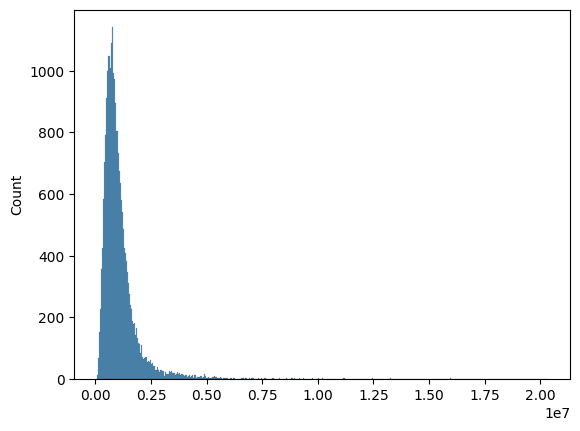

In [30]:
print(y_pred_hgb_best.min())
print(y_pred_hgb_best.max())

sns.histplot(y_pred_hgb_best)
plt.show()

### Predictions from Best Model yet

In [31]:
pred_best = pd.read_csv('../../../data/predictions_best.csv')

pred_best = pred_best["Expected"]

sns.histplot(pred_best)
plt.show()

print(pred_best.min())
print(pred_best.max())

FileNotFoundError: [Errno 2] No such file or directory: '../../../data/predictions_best.csv'